In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from datetime import datetime
import json
import os

from IPython.display import JSON
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import s3fs

os.environ['AWS_PROFILE'] = 'waisman-admin'
sns.set_theme(
    context='paper', style='ticks', palette='muted')


In [3]:
log_list = [
    # 's3://nkalafut-celltrip/logs/3gpu-2learn-6run-100iter-2.log',
    # 's3://nkalafut-celltrip/logs/3gpu-2learn-6run-100iter-3.log',
    # 's3://nkalafut-celltrip/logs/3gpu-2learn-6run-100iter-4.log',  # No replay
    # 's3://nkalafut-celltrip/logs/3gpu-2learn-6run-100iter-5.log',  # .5 replay
    # 's3://nkalafut-celltrip/logs/3gpu-2learn-6run-100iter-6.log',  # .25 replay - Interesting discovery at beginning
    # 's3://nkalafut-celltrip/logs/3gpu-2learn-6run-100iter-7.log',  # No replay, no entropy bonus - trying to lower entropy - maybe next time start at mid entropy with small bonus? Maybe multiply entropy grad by some value to simulate higher lr? Current vel pen might be harsh, too
    # 's3://nkalafut-celltrip/logs/3gpu-2learn-6run-100iter-8.log',  # Same but with action_std lr 3e-3
    # 's3://nkalafut-celltrip/logs/3gpu-2learn-6run-100iter-9.log',  # Same but with action_std lr 1e-1
    # 's3://nkalafut-celltrip/logs/5gpu-2learn-5run-100iter-10.log',  # Add entropy bonus, use KL targeting rather than ES (VERY GOOD)
    # 's3://nkalafut-celltrip/logs/5gpu-Replay.log',  # Replay, change beta inc., imputation
    # 's3://nkalafut-celltrip/logs/5gpu-Replay-2.log',  # Change beta inc. strategy
    # 's3://nkalafut-celltrip/logs/5gpu-Replay-3.log',  # Change replay
    # 's3://nkalafut-celltrip/logs/2gpu-NoReplay.log',  # Change replay  (VERY GOOD)
    # 's3://nkalafut-celltrip/logs/3gpu-9k-ExtraKL.log',  # 9K samples and .03 -> .1 target KL  (MUCH FASTER!)
    # 's3://nkalafut-celltrip/logs/3gpu-9k-ExtraKL-2.log',  # Longer run of previous
    # 's3://nkalafut-celltrip/logs/3gpu-9k-ExtraKL-DontSync.log',  # Same but don't sync across nodes
    # 's3://nkalafut-celltrip/logs/3gpu-1k.log',  # Same but 1k cells
    # 's3://nkalafut-celltrip/logs/3gpu-1k-cont.log',
    # 's3://nkalafut-celltrip/logs/3gpu-new.log',  # New params
    # 's3://nkalafut-celltrip/logs/3gpu-new-lite.log',  # Lite
    's3://nkalafut-celltrip/logs/3gpu-new-arch.log',  # New shared architecture
    # Add train/val then can train final models
    # Maybe move KL target during training? - REVISE KL AGGREGATION ACROSS NODES, RIGHT NOW AVERAGES TO 1.25 AND TENDS HIGH
    # Try weight reg
    # Maybe try doing ES based on action_std/entropy?
    # Have actor/critic share model
]


In [4]:
# TODO: Compatibility with appending logfiles (i.e. checkpoints)
s3 = s3fs.S3FileSystem()
def convert_json(s):
    s = s.replace('\'', '"').replace('False', 'false').replace('True', 'true')
    s_json = json.loads(s)
    s_json['Timestamp'] = datetime.strptime(s_json['Timestamp'], '%Y-%m-%d %H:%M:%S.%f')  # Convert to datetime
    return s_json
records = []
for fname in log_list:
    # TODO: Add local files
    with s3.open(fname, 'r') as f:
        records += [convert_json(record) for record in f.read().split('\n') if len(record) > 0]
assert len(records) > 3, 'Logfile(s) is empty! If currently running, try waiting for flush'


AssertionError: Logfile(s) is empty! If currently running, try waiting for flush

In [ ]:
# Generate df
df_records = pd.DataFrame(records)
for col in ('Itemized Reward', 'Losses'):
    try: df_records = pd.concat((df_records.drop(columns=col), pd.json_normalize(df_records[col])), axis=1)
    except: print(f'Column {col} not found, might be missing some event types. '
                  f'This is expected if running early in training.')
# begin_time = df_records.loc[df_records['Event Type']=='Begin Training', 'Timestamp'].iloc[0]
# begin_time = df_records.loc[df_records['Event Type']=='Register Workers', 'Timestamp'].iloc[0]
# df_records['Timestamp'] = df_records['Timestamp'].apply(lambda t: (t-begin_time).total_seconds() / timestamp_divisor)
# df_records['Timestamp'] = df_records['Timestamp'].apply(lambda t: t.total_seconds() / timestamp_divisor)
timestamps = pd.Series()
timestamp_divisor = 60**1  # Minutes
trial_begin_time = None; last_trial_end_time = 0
for i in range(df_records.shape[0]):
    if df_records.loc[i, 'Event Type'] == 'Begin Training':
        if trial_begin_time is not None:
            last_trial_end_time = timestamps.iloc[-1]
        trial_begin_time = df_records.loc[i, 'Timestamp']
    timestamps.loc[i] = last_trial_end_time + (df_records.loc[i, 'Timestamp'] - trial_begin_time).total_seconds() / timestamp_divisor
df_records['Timestamp'] = timestamps

# Get spans
from collections import defaultdict
span_dict = defaultdict(lambda: [])
for _, r in df_records.iterrows():
    span_dict[r['Event Type']].append(
        (r['Timestamp']-(r['Time'] if r['Time'] is not None else 0)/timestamp_divisor, r['Timestamp']))
    
# Squash span dict
span_dict_squashed = {}
for k in span_dict:
    squashed = []
    for v1 in span_dict[k]:
        i = 0
        while i < len(squashed):
            v2 = squashed[i]
            if v1[0] < v2[1] and v2[0] < v1[1]:
                # Repropagate with combined span
                squashed.pop(i)
                v1 = (min(v1[0], v2[0]), max(v1[1], v2[1]))
                i = 0
                continue
            i += 1
        squashed.append(v1)
    span_dict_squashed[k] = squashed


In [ ]:
# Event filter
def event_filter(df, event_type):
    return (df
        .loc[df['Event Type'] == event_type]
        .dropna(axis=1).drop(columns=['Event Type']))

def group_policy(df, agg='mean'):
    df = df.drop(columns=['Rank']).groupby('Policy Iteration')
    if agg == 'mean': df = df.mean()
    elif agg == 'min': df = df.min()
    elif agg == 'max': df = df.max()
    elif agg == 'std': df = df.std()
    return df.reset_index()


In [ ]:
group_policy(event_filter(df_records, 'Rollout'))


,Policy Iteration,Timestamp,Timesteps,Memories,Reward,Time,distance,origin,bound,velocity,action
0,0.0,3.168140,500.0,1000000.0,-229.641663,14.398901,0.0,0.0,-229.641663,0.0,0.0
1,1.0,3.730131,500.0,1000000.0,-332.558370,13.480672,0.0,0.0,-332.558370,0.0,0.0
2,2.0,4.302606,500.0,1000000.0,-268.041718,13.365755,0.0,0.0,-268.041718,0.0,0.0
3,3.0,4.880773,500.0,1000000.0,-178.983360,13.675788,0.0,0.0,-178.983360,0.0,0.0
4,4.0,5.455277,500.0,1000000.0,-179.758321,13.617182,0.0,0.0,-179.758321,0.0,0.0
5,5.0,6.029764,500.0,1000000.0,-162.866692,13.712699,0.0,0.0,-162.866692,0.0,0.0
6,6.0,6.609207,500.0,1000000.0,-185.858294,13.784324,0.0,0.0,-185.858294,0.0,0.0
7,7.0,7.190964,500.0,1000000.0,-178.700010,13.650286,0.0,0.0,-178.700010,0.0,0.0
8,8.0,7.772573,500.0,1000000.0,-163.583331,13.663157,0.0,0.0,-163.583331,0.0,0.0
9,9.0,8.352093,500.0,1000000.0,-162.458359,13.752175,0.0,0.0,-162.458359,0.0,0.0


In [ ]:
group_policy(event_filter(df_records, 'Update'))


,Policy Iteration,Timestamp,Time,New Memories,Replay Memories,Total Memories,Iterations,Log STD,Advantage STD,Total,PPO,critic,entropy,KL
0,1.0,3.498765,16.388041,1800000.0,0.0,1800000.0,4.0,-1.120160,4.174490,1.920875,0.015277,3.812881,-0.961555,1.399928e-01
1,2.0,4.073805,16.812839,1800000.0,1800000.0,3600000.0,4.0,-0.862596,7.527451,0.879832,-0.014906,1.734715,-1.051679,4.085022e-01
2,3.0,4.646643,16.673022,1800000.0,3600000.0,5400000.0,4.0,-1.006757,10.803886,0.202146,-0.003278,0.413837,-1.494970,2.081140e-02
3,4.0,5.222135,16.613849,1800000.0,5400000.0,7200000.0,4.0,-1.096405,12.699570,0.132096,0.000838,0.264522,-1.002856,2.731228e-02
4,5.0,5.794720,16.612588,1800000.0,7200000.0,9000000.0,4.0,-1.142647,14.388578,0.087602,0.001788,0.173878,-1.125029,1.508129e-02
5,6.0,6.373286,16.642176,1800000.0,9000000.0,10800000.0,4.0,-0.963154,15.930872,0.050251,-0.000897,0.104380,-1.041596,3.129550e-02
6,7.0,6.957144,16.785543,1800000.0,9000000.0,10800000.0,4.0,-1.025544,17.956551,0.037788,0.000987,0.076357,-1.377573,3.120520e-03
7,8.0,7.538570,16.696825,1800000.0,9000000.0,10800000.0,4.0,-1.134996,19.582754,0.025881,0.000009,0.053922,-1.088883,1.013107e-02
8,9.0,8.116309,16.639982,1800000.0,9000000.0,10800000.0,4.0,-1.140382,20.725669,0.021512,0.001177,0.041964,-0.646954,2.042882e-02
9,10.0,8.699140,16.671402,1800000.0,9000000.0,10800000.0,4.0,-1.210631,21.808785,0.017615,-0.000033,0.036563,-0.633705,1.833558e-02


In [ ]:
# Register colors
reward_colors = {
    'total': 'black', 'distance': 'darkturquoise',
    'origin': 'darkgreen', 'bound': 'red',
    'velocity': 'orange', 'action': 'gold'}
event_colors = {
    'Rollout': 'lightcoral', 'Update': 'paleturquoise',
    'Send Memory': 'khaki', 'Receive Memories': 'burlywood',
    'Synchronize Policy': 'darkseagreen',
    'Save Checkpoint': 'brown', 'Load Checkpoint': 'brown',
    'Other': 'brown'}


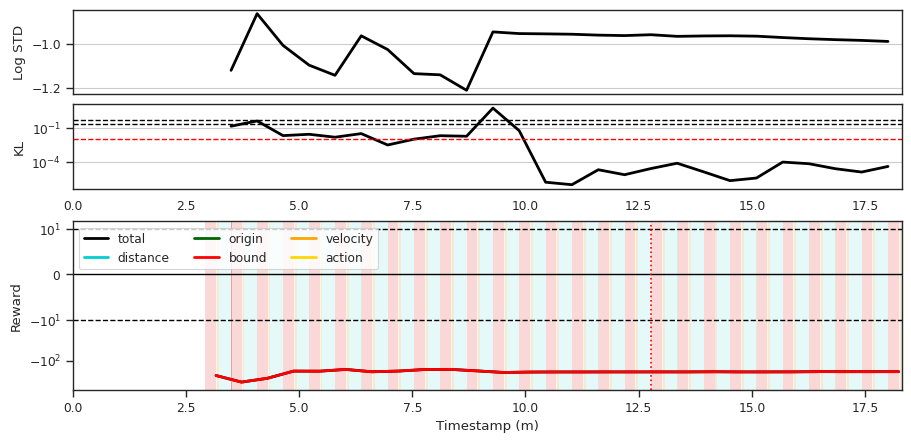

In [ ]:
# Melt functions
def melt_rewards_rollout(df):
    df = df[[
        'Timestamp', 'Reward', 'distance', 'origin',
        'bound', 'velocity', 'action']].rename(
            columns={'Reward': 'total'}
        ).melt(
            id_vars='Timestamp', var_name='Reward',
            value_name='Value')
    return df

def melt_rewards_update(df):
    df = df[[
        'Timestamp', 'Iterations', 'Log STD', 'PPO',
        'critic', 'entropy', 'KL']].melt(
            id_vars='Timestamp', var_name='Parameter',
            value_name='Value')
    return df

# Filter function
def filter_zero(df):
    df.loc[df['Value'] == 0, 'Value'] = pd.NA
    return df

# Line plot function
def gap_plot(df, x, y, hue, palette, ax, legend=True, plot_type='line', **kwargs):
    # sns.lineplot(
    #     melt_rewards(group_policy(event_filter('Rollout'))),
    #     x='Timestamp', y='Value', hue='Reward', palette=reward_colors,
    #     lw=2, ax=ax)
    for h in df[hue].unique():
        df_filt = df.loc[df[hue]==h]
        if plot_type == 'line':
            ax.plot(df_filt[x], df_filt[y], color=palette[h], label=h if legend else None, **kwargs)
        elif plot_type == 'scatter':
            ax.scatter(df_filt[x], df_filt[y], color=palette[h], label=h if legend else None, **kwargs)

# Plot
fig = plt.figure(figsize=(9, 6), layout='constrained')
ax1 = plt.subplot2grid((6, 2), (2, 0), 2, 2, fig)
df_raw = melt_rewards_rollout(event_filter(df_records, 'Rollout'))
df_mean = melt_rewards_rollout(group_policy(event_filter(df_records, 'Rollout'), agg='mean'))
df_std = melt_rewards_rollout(group_policy(event_filter(df_records, 'Rollout'), agg='std'))
df_min = melt_rewards_rollout(group_policy(event_filter(df_records, 'Rollout'), agg='min'))
df_max = melt_rewards_rollout(group_policy(event_filter(df_records, 'Rollout'), agg='max'))
## Shading
for h in df_raw['Reward'].unique():
    mask = df_min['Reward'] == h
    # Max min
    x = df_mean.loc[mask, 'Timestamp']
    # lower, upper = df_min.loc[mask, 'Value'], df_max.loc[mask, 'Value']  # Max min
    lower, upper = df_mean.loc[mask, 'Value'] - 1.96*df_std.loc[mask, 'Value'], df_mean.loc[mask, 'Value'] + 1.96*df_std.loc[mask, 'Value']  # STD
    # Filter zeros
    zero_mask = (lower == 0) * (upper == 0)
    lower[zero_mask] = upper[zero_mask] = pd.NA
    # Fill
    ax1.fill_between(
        x, lower, upper, lw=0, color=reward_colors[h], alpha=.35)
    # Line
    # for x_val, lower_val, upper_val in zip(x.to_numpy(), lower.to_numpy(), upper.to_numpy()):
    #     ax.plot([x_val, x_val], [lower_val, upper_val], lw=2, color=reward_colors[h])
## Points
# gap_plot(
#     filter_zero(df_raw), x='Timestamp', y='Value', hue='Reward',
#     palette=reward_colors, s=2, legend=False, ax=ax, plot_type='scatter')
## Mean line
gap_plot(
    filter_zero(df_mean), x='Timestamp', y='Value', hue='Reward',
    palette=reward_colors, lw=2, ax=ax1, plot_type='line')
# Stages
for i, r in event_filter(df_records, 'Advance Stage').iterrows():
    ax1.axvline(r['Timestamp'], color='black', ls=':', lw=2, zorder=.2)
# Formatting
# sns.despine(ax=ax1)
ax1.set(xlabel='Timestamp (m)', ylabel='Reward')
ax1.set_xlim(left=0, right=np.max([span_dict_squashed[k][-1][1] for k in span_dict]))
# ax1.set_ylim(bottom=-2.6)
linthresh = 1e1
ax1.set_yscale('symlog', base=10, linthresh=linthresh)
for s in (-1, 1): ax1.axhline(y=s*linthresh, color='black', lw=1, ls='--', zorder=.2)
ax1.axhline(y=0, color='black', lw=1, ls='-', zorder=.2)
for k in span_dict_squashed.keys():
    if k not in event_colors: continue
    for xmin, xmax in span_dict_squashed[k]: ax1.axvspan(xmin, xmax, color=event_colors[k], alpha=.3, lw=0, zorder=.1)
ax1.legend(loc='upper left', ncols=3)
# Entropy
ax2 = plt.subplot2grid((6, 2), (0, 0), 1, 2, fig, sharex=ax1)
df_update = group_policy(event_filter(df_records, 'Update'), agg='mean')
# sns.lineplot(
#     melt_rewards_update(df_update), x='Timestamp', y='Value', hue='Parameter')
# ax2.set_yscale('symlog')
ax2.plot(
    df_update['Timestamp'], df_update['Log STD'], lw=2, color='black')
    # lw=1, color='white', path_effects=[pe.Stroke(linewidth=2, foreground='black'), pe.Normal()]
ax2.set_ylabel('Log STD')
# ax2.set_ylim(bottom=0)
ax2.grid(axis='y', which='both', visible=True)
# ax1.grid(which='both', visible=True)
ax2.tick_params(axis='x', which='both', bottom=False)
plt.setp(ax2.get_xticklabels(), visible=False)
# ax2.legend(loc='upper right')
# KL
ax3 = plt.subplot2grid((6, 2), (1, 0), 1, 2, fig, sharex=ax1)
df_update = group_policy(event_filter(df_records, 'Update'), agg='mean')
ax3.plot(
    df_update['Timestamp'], df_update['KL'], lw=2, color='black')
kl_target = .3
ax3.axhline(y=kl_target*1.5, ls='--', lw=1, color='black')
ax3.axhline(y=kl_target/1.5, ls='--', lw=1, color='black')
ax3.set_yscale('log')
ax3.set_ylabel('KL')
ax3.grid(axis='y', which='both', visible=True)
ax3.tick_params(axis='x', which='both', bottom=False)
plt.setp(ax2.get_xticklabels(), visible=False)

# Early stopping based on KL
count = 0; es_timestep = None; lapses = 5; es_threshold = 1e-2
for i, r in group_policy(event_filter(df_records, 'Update')).iterrows():
    count = count + 1 if r['KL'] < es_threshold else 0
    if count >= lapses:
        es_timestep = r['Timestamp']
        break
if es_timestep is not None: ax1.axvline(x=es_timestep, ls=':', color='red')
ax3.axhline(y=es_threshold, ls='--', lw=1, color='red')

# Display
# ax1.axhline(y=.03)
fig.show()


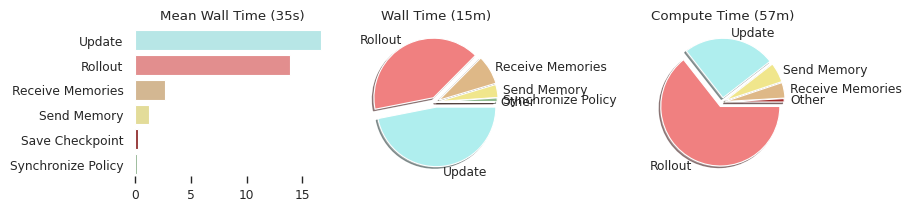

In [ ]:
# Processing functions
def group_small(df):
    mask = (df['Time'] / df['Time'].sum()) < .01
    if mask.sum() > 0:
        other_row = df.loc[mask].sum()
        df = df.loc[~mask].copy()
        df.loc['Other'] = other_row
    return df

# Get times
span_times = {k: timestamp_divisor*np.sum([v2[1]-v2[0] for v2 in v1]) for k, v1 in span_dict_squashed.items()}
df_walltime = pd.DataFrame(span_times.values(), index=span_times.keys(), columns=['Time'])
df_walltime.index.name = 'Event Type'
df_walltime = df_walltime.loc[df_walltime['Time'] != 0].dropna()
df_walltime['Mean Time'] = df_walltime.apply(lambda r: r['Time'] / len(span_dict_squashed[r.name]), axis=1)
df_comptime = df_records.groupby('Event Type').sum()[['Time']]
df_comptime = df_comptime.loc[df_comptime['Time'] != 0].dropna()
df_comptime['Mean Time'] = df_comptime.apply(lambda r: r['Time'] / len(span_dict_squashed[r.name]), axis=1)

# Plot function
def plot_pie(df, ax):
    labels = df.index.to_numpy()
    sizes = df['Time'].to_numpy()
    colors = [event_colors[l] for l in labels]
    explode = .3 * np.log(sizes) / np.log(sizes).sum()
    # explode = np.zeros_like(sizes)
    # explode[np.argsort(sizes).flatten()[-2:]] = .1
    ax.pie(
        sizes, explode=explode, labels=labels, colors=colors,  # autopct='%1.1f%%',
        shadow=True, startangle=0, counterclock=False, rotatelabels=False)

# Plot
fig = plt.figure(figsize=(9, 2), layout='constrained')
ax1 = plt.subplot2grid((1, 3), (0, 1), 1, 1, fig=fig)
plot_pie(group_small(df_walltime.sort_values('Time', ascending=False)), ax1)
ax1.set(title=f'Wall Time ({df_walltime.sum()["Time"]/60:.0f}m)')
ax2 = plt.subplot2grid((1, 3), (0, 2), 1, 1, fig=fig)
plot_pie(group_small(df_comptime.sort_values('Time', ascending=False)), ax2)
ax2.set(title=f'Compute Time ({df_comptime.sum()["Time"]/60:.0f}m)')
ax3 = plt.subplot2grid((1, 3), (0, 0), 1, 1, fig=fig)
sns.barplot(
    df_walltime.sort_values('Mean Time', ascending=False), y='Event Type', x='Mean Time', hue='Event Type',
    palette=event_colors, ax=ax3)
sns.despine(left=True, bottom=True, ax=ax3)
ax3.set(title=f'Mean Wall Time ({df_walltime.sum()["Mean Time"]:.0f}s)', xlabel=None, ylabel=None)
ax3.tick_params(axis='y', which='major', left=False)
# ax3.set_yticks([])
fig.show()


In [ ]:
# # Format
# df_rollout = group_policy(event_filter(df_records, 'Rollout'), agg='mean')
# df_update = group_policy(event_filter(df_records, 'Update'), agg='mean')
# df_combined = df_rollout.join(df_update, rsuffix='_update')

# # Plot
# fig = plt.figure(figsize=(6, 6), layout='constrained')
# ax1 = plt.subplot2grid((1, 1), (0, 0), 1, 1, fig=fig)
# sns.scatterplot(df_combined, x='Log STD', y='distance', hue='Timestamp', ax=ax1)
# ax1.set_yscale('symlog')
# ax1.invert_xaxis()
# fig.show()
